In [30]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import glob

import gensim
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel

import pyLDAvis
from pyLDAvis import gensim_models 

import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import re
import os
import sys
import ast
from textblob import TextBlob
import string
import spacy
nlp = spacy.load('en_core_web_sm')
from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.decomposition import LatentDirichletAllocation
from datetime import datetime

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ZBOOK\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
organic_food_reddit = pd.read_csv('organic food headlines.csv', sep=',', index_col= None) \
    .drop(columns='Unnamed: 0')

# organic_food_reddit.sample(2)

In [3]:
# Extract exact dates

old_dates = organic_food_reddit['created']

date_time = [datetime.utcfromtimestamp(date).strftime('%Y-%m-%d %H:%M:%S') for date in old_dates]

date = pd.to_datetime(date_time)

organic_food_reddit['date'] = date.date
organic_food_reddit = organic_food_reddit.drop(columns='created').drop_duplicates()
# organic_food_reddit.sample(2)

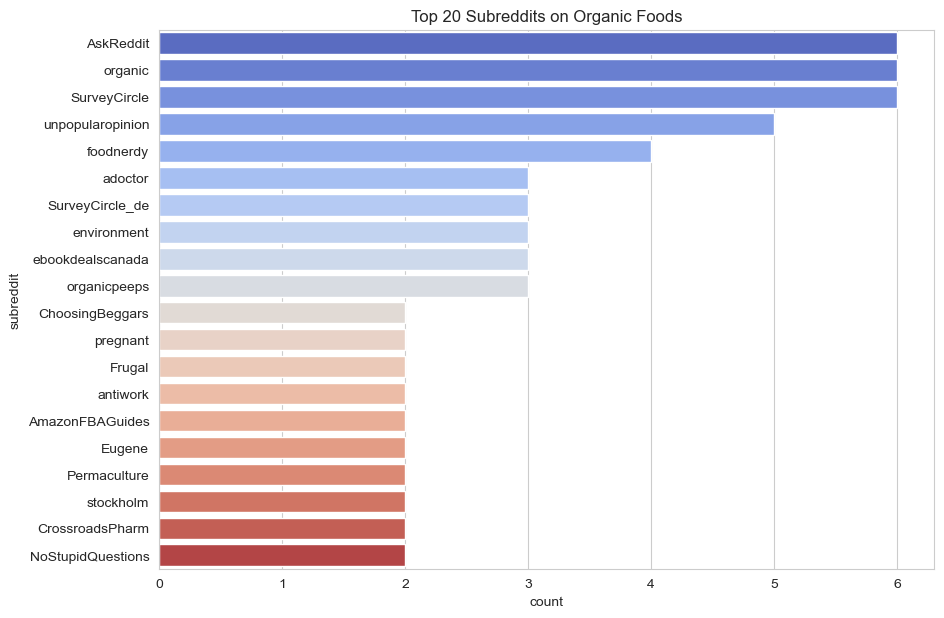

In [4]:
# Subreddits Descriptive Stats
sns.set_style('whitegrid')
subreddits = organic_food_reddit['subreddit'].value_counts().sort_values(ascending=False).head(20).reset_index()
subreddits.shape
plt.figure(figsize=(10,7))
plt.title("Top 20 Subreddits on Organic Foods")
sns.barplot(subreddits, x='count', y='subreddit', errorbar='sd', palette='coolwarm')
plt.show()


c:\Users\ZBOOK\AppData\Local\r-miniconda\envs\sentiment_analysis\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


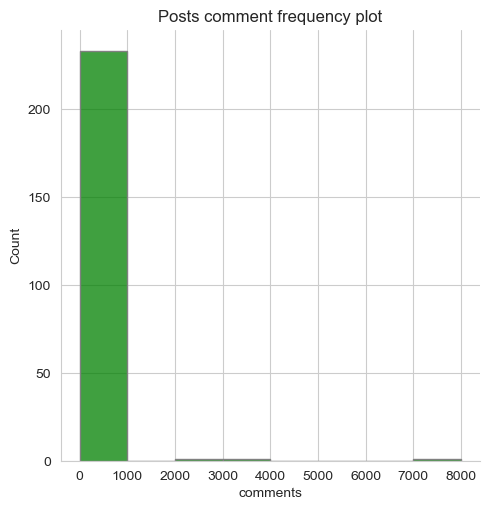

In [5]:
# Content comments / votes distribution

sns.displot(
    data=organic_food_reddit, 
    x='comments', 
    binwidth = 1000, 
    color= 'green', 
    edgecolor= 'gray')
plt.title('Posts comment frequency plot')
plt.show()

c:\Users\ZBOOK\AppData\Local\r-miniconda\envs\sentiment_analysis\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


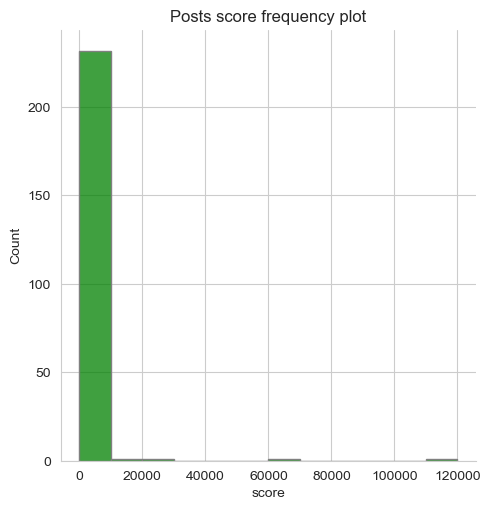

In [6]:
# Content score / votes distribution

sns.displot(
    data=organic_food_reddit, 
    x='score', 
    binwidth = 10000, 
    color= 'green', 
    edgecolor= 'gray')
plt.title('Posts score frequency plot')
plt.show()

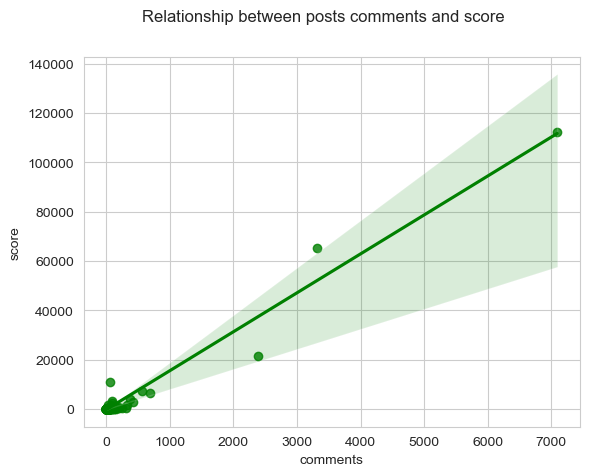

In [7]:
sns.set_style('whitegrid')
sns.regplot(organic_food_reddit, x='comments', y='score', color='green')
plt.suptitle('Relationship between posts comments and score')
plt.show()

In [8]:
# Handle words contractions

def handle_contractions(text):
    contractions = {
        "n't": " not",
        "'s" : " is",
        "'d" : " would",
        "'ve" : " have",
        "'re": " are",
        "'ll": " will",
        "'m": " am"
    }
    
    words = text.split()
    for i in range(len(words)):
        if words[i] in contractions:
            words[i] = contractions[words[i]]
    return ' '.join(words)


In [9]:
# Preprocess text, remove stopwords, tokenize and Lemmatize

def preprocess_text(text, freq_words=False):
    text = text.lower()
    
    ## remove numbers from the text
    text = re.sub(r"\d+", '', text)
    
    ## removing punctuations
    text = ''.join([char for char in text if char not in string.punctuation])
    
    ## Tokenize text
    tokens = word_tokenize(text)
    
    ## Remove stopwords
    stop_words = stopwords.words("english")
    if freq_words:
        stop_words.extend(['organic', 'food', 'foods', '“', '’', '”', '‘'])
    tokens = [token for token in tokens if token not in stop_words]
    
    ## Remove contractions from words
    text = handle_contractions(' '.join(tokens))
    
    ## Lemmatize the words
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in word_tokenize(text)]
    
    return ' '.join(tokens)


In [10]:
organic_food_reddit['cleaned_title'] = organic_food_reddit['title'].apply(preprocess_text)

In [11]:
# Calculate sentiments

def percentage(val, total):
    return (val / total) * 100

# Sentiment Scores
def get_sentiment_scores(text_array):
    
    positive = 0
    negative = 0
    neutral = 0

    scores = []

    content_list = []

    positive_list = []
    negative_list = []
    neutral_list = []

    contents = text_array
    
    subjectivity_score = contents.apply(lambda x: TextBlob(x).sentiment.subjectivity)
    polarity_score = contents.apply(lambda x: TextBlob(x).sentiment.polarity)

    for content in contents:
        #print(content)
        content_list.append(content)
        score = SentimentIntensityAnalyzer().polarity_scores(content)
        neg_score = score['neg']
        pos_score = score['pos']
        neu_score = score['neu']    
        
        scores.append([neg_score, pos_score, neu_score])
        
        if neg_score > pos_score:
            negative_list.append(content)
            negative += 1
        elif neg_score < pos_score:
            positive_list.append(content)
            positive += 1
        elif neg_score == pos_score:
            neutral_list.append(content)
            neutral += 1
            
    positive = percentage(positive, len(contents))
    negative = percentage(negative, len(contents))
    neutral = percentage(neutral, len(contents))

    positive = format(positive, '.1f')
    negative = format(negative, '.1f')
    neutral = format(neutral, '.1f')
    
    
    return {
        'polarity': polarity_score,
        'subjectivity': subjectivity_score,
        'scores': scores,
        'positive': positive,
        'negative': negative,
        'neutral' : neutral
    }

In [12]:
# get sentiment scores
all_scores = get_sentiment_scores(organic_food_reddit['cleaned_title'])

# add sentiment scores to dataframe
organic_food_reddit_scores = organic_food_reddit.reset_index()\
    .merge(pd.DataFrame(all_scores['scores'], columns=["neg", "pos", "neu"]).reset_index())

# add polarity and subjectivity scores to dataframe
organic_food_reddit_scores['polarity'] = all_scores['polarity']
organic_food_reddit_scores['subjectivity'] = all_scores['subjectivity']

# percentages of positive, negative and neutral
positive = all_scores['positive']
negative = all_scores['negative']
neutral = all_scores['neutral']

# attach sentiment scores
organic_food_reddit_scores.loc[organic_food_reddit_scores['neg'] > organic_food_reddit_scores['pos'], "sentiment_label"] = "negative"
organic_food_reddit_scores.loc[organic_food_reddit_scores['pos'] > organic_food_reddit_scores['neg'], "sentiment_label"] = "positive"
organic_food_reddit_scores.loc[organic_food_reddit_scores['neg'] == organic_food_reddit_scores['pos'], "sentiment_label"] = "neutral"

organic_food_reddit_scores.sample(2)

,index,title,subreddit,score,id,url,comments,body,date,cleaned_title,neg,pos,neu,polarity,subjectivity,sentiment_label
36,36,Introducing healthy and delicious Organic Food!,chemistrymemes,317,12b20t7,https://i.redd.it/uz0bpoq28rra1.jpg,8,NaN,2023-04-03,introducing healthy delicious organic food,0.000,0.681,0.319,0.75,0.750000,positive
70,70,Organic food is bad,unpopularopinion,31,zlkmqi,https://www.reddit.com/r/unpopularopinion/comm...,124,"I don't know how unpopular this is, but it is ...",2022-12-14,organic food bad,0.636,0.000,0.364,-0.70,0.666667,negative


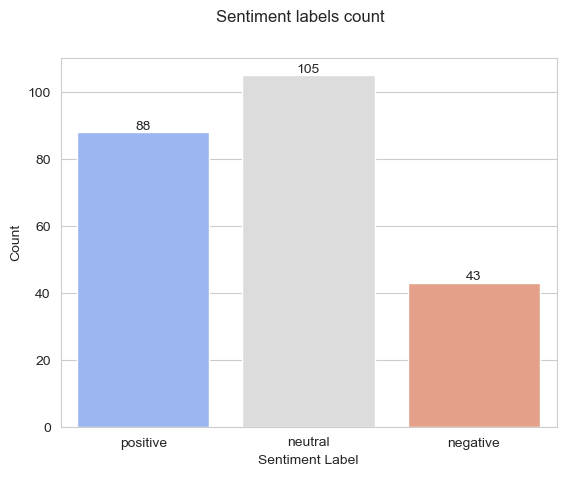

In [13]:
# sentiment labels barplot

plt.suptitle('Sentiment labels count')
sns.set_style('whitegrid')
ax = sns.countplot(data=organic_food_reddit_scores, x="sentiment_label", palette='coolwarm')
ax.bar_label(ax.containers[0], fmt='%.0f', label_type = 'edge')
plt.xlabel('Sentiment Label')
plt.ylabel('Count')
plt.show()

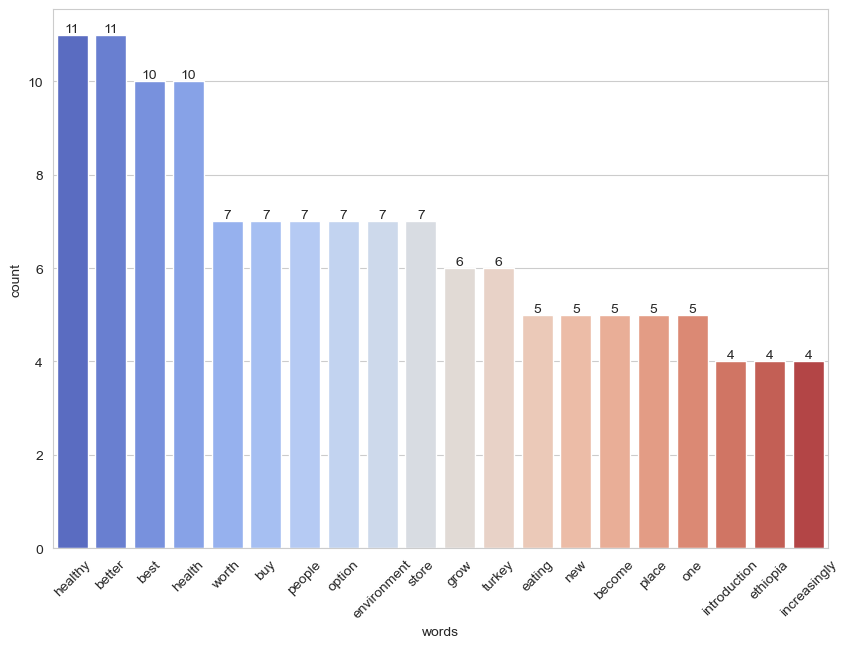

In [14]:
# word frequency for positive sentiments

positive_df = organic_food_reddit_scores.loc[organic_food_reddit_scores['sentiment_label'] == 'positive']['cleaned_title']
positive_words = " ".join(positive_df.apply(preprocess_text, freq_words = True))
words_count = Counter(positive_words.split())
most_freq = words_count.most_common(20)

fig = plt.figure(figsize=(10, 7))
_ = pd.DataFrame(most_freq, columns=("words", "count"))
ax = sns.barplot(x="words", y = "count", data=_, palette="coolwarm")
plt.xticks(rotation=45)
ax.bar_label(ax.containers[0], fmt='%.0f', label_type = 'edge')
plt.show()


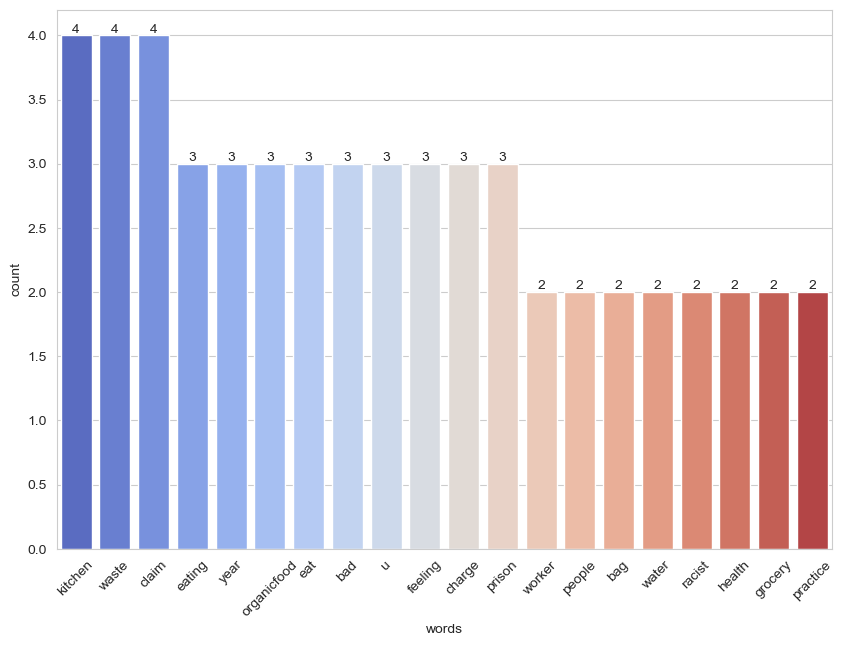

In [15]:
negative_df = organic_food_reddit_scores.loc[organic_food_reddit_scores['sentiment_label'] == 'negative']['cleaned_title']
negative_words = " ".join(negative_df.apply(preprocess_text, freq_words = True))
words_count = Counter(negative_words.split())
most_freq = words_count.most_common(20)

fig = plt.figure(figsize=(10, 7))
_ = pd.DataFrame(most_freq, columns=("words", "count"))
ax = sns.barplot(x="words", y = "count", data=_, palette="coolwarm")
plt.xticks(rotation=45)
ax.bar_label(ax.containers[0], fmt='%.0f', label_type = 'edge')
plt.show()

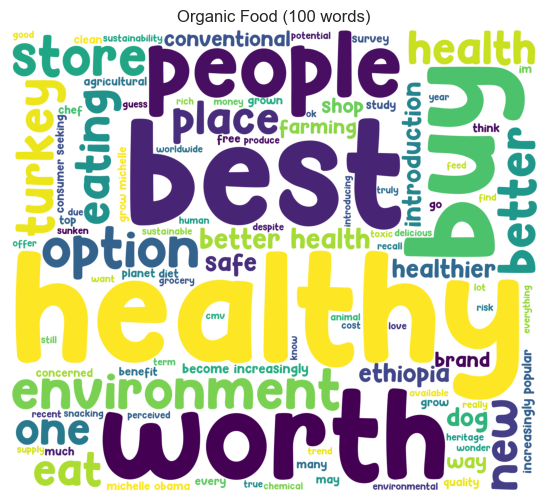

In [16]:
wordcloud_positive = WordCloud(
    background_color='white',
    max_words=100,
    height=1400,
    width=1600,
    font_path="hey_comic/Hey Comic.ttf"
).generate(positive_words)

plt.figure(figsize=(8,6))
plt.imshow(wordcloud_positive)
plt.title("Organic Food (100 words)")
plt.axis('off')
plt.show()


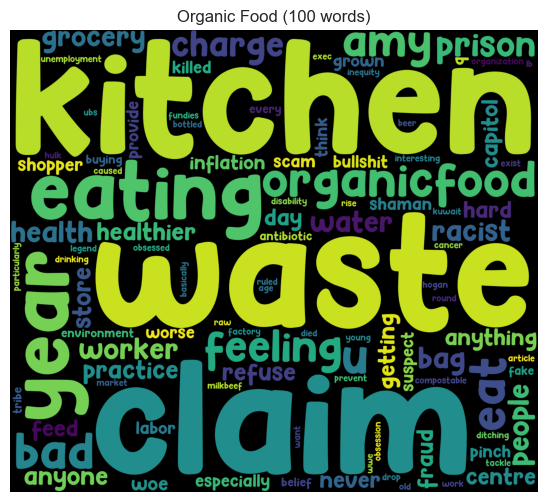

In [17]:
wordcloud_negative = WordCloud(
    background_color='black',
    max_words=100,
    height=1400,
    width=1600,
    font_path="hey_comic/Hey Comic.ttf"
).generate(negative_words)

plt.figure(figsize=(8,6))
plt.imshow(wordcloud_negative)
plt.title("Organic Food (100 words)")
plt.axis('off')
plt.show()

### Bag of words model

In order to use text as an input to machine learning algorithms, we need to present it in a numerical format. Bag-of-words is a vector space model and represents the occurrence of words in the document. In other words, bag-of-words converts each review into a collection of word counts without giving importance to the order or meaning.

In [25]:
# Bag of words model

# create dictionary
organic_food_reddit_scores['cleaned_title_list'] = [list(sent.split()) for sent in organic_food_reddit_scores['cleaned_title'].apply(preprocess_text, freq_words = True)]
id2word = gensim.corpora.Dictionary(organic_food_reddit_scores['cleaned_title_list'])

corpus = [id2word.doc2bow(text) for text in organic_food_reddit_scores['cleaned_title_list']]


### Determining the Number of Topics
Deciding on the number of topics for the topic modeling can be difficult. Since we have initial knowledge of the context, determining the number of topics for modeling wouldn't be too outraging. However, if this number is too much then the model might fail to detect a topic that is actually broader and if this number is too less then topics might have large overlapping words. Because of these reasons, we will use the topic coherence score.

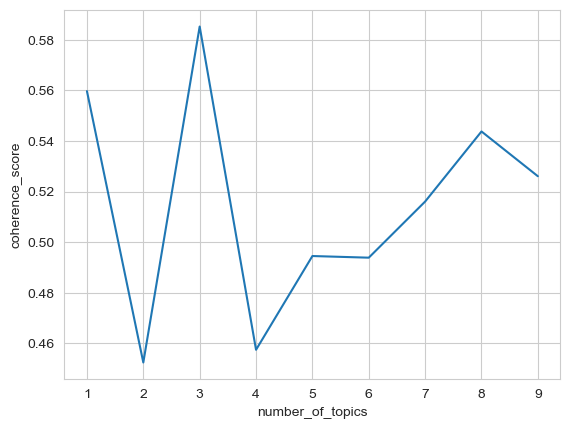

In [26]:
# Using coherence model to determine the number of topics

num_topics = []
coherence_score = []

text = organic_food_reddit_scores['cleaned_title_list']

for i in range(1, 10):
    lda_model = LdaModel(corpus=corpus, id2word = id2word, iterations = 50, num_topics = i)
    coherence_model = CoherenceModel(model=lda_model, texts=text, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model.get_coherence()
    num_topics.append(i)
    coherence_score.append(coherence_lda)
    
# Create a dataframe of coherence score by number of topics
topic_coherence = pd.DataFrame({'number_of_topics': num_topics,
                                'coherence_score': coherence_score})

sns.lineplot(data=topic_coherence, x='number_of_topics', y='coherence_score')
plt.show()

A very high coherence score is achieved with just 3 topics, then we will construct our LDA model with just 3 topics.

In [27]:
# Topic modelling with LDA

# number of topics
n_topics = 3

lda_model = LdaModel(
    corpus=corpus, 
    id2word=id2word, 
    num_topics=n_topics, 
    random_state=100, 
    update_every=1, 
    chunksize=10,
    passes=10,
    alpha='symmetric',
    iterations=100,
    per_word_topics=True
)

for idx, topic in lda_model.print_topics(-1):
    print(f"Topic: {idx} Word: {topic}")


Topic: 0 Word: 0.019*"every" + 0.013*"one" + 0.013*"tribe" + 0.010*"please" + 0.010*"buy" + 0.010*"–" + 0.009*"well" + 0.009*"toxic" + 0.009*"eat" + 0.009*"free"
Topic: 1 Word: 0.017*"survey" + 0.014*"store" + 0.011*"affordable" + 0.011*"new" + 0.010*"kitchen" + 0.010*"real" + 0.009*"know" + 0.009*"turning" + 0.009*"grew" + 0.009*"opinion"
Topic: 2 Word: 0.018*"better" + 0.018*"people" + 0.017*"grown" + 0.013*"healthy" + 0.012*"environment" + 0.010*"health" + 0.009*"eating" + 0.009*"get" + 0.009*"land" + 0.008*"way"


In [33]:
# Visualize with pyLDAvis

pyLDAvis.enable_notebook()

vis = gensim_models.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.108737  0.108211       1        1  35.823178
1     -0.152736  0.035607       2        1  32.580978
0      0.044000 -0.143818       3        1  31.595844, topic_info=         Term       Freq      Total Category  logprob  loglift
402     every  10.000000  10.000000  Default  30.0000  30.0000
234    better  11.000000  11.000000  Default  29.0000  29.0000
649     grown  10.000000  10.000000  Default  28.0000  28.0000
642    survey   9.000000   9.000000  Default  27.0000  27.0000
14     people  12.000000  12.000000  Default  26.0000  26.0000
..        ...        ...        ...      ...      ...      ...
923  polluted   3.217422   4.255868   Topic3  -5.1022   0.8724
924  progress   3.217422   4.255868   Topic3  -5.1022   0.8724
926    within   3.217422   4.255868   Topic3  -5.1022   0.8724
173     water   3.811812   6.808471   Topic3  -4.9327   0.5721
410       say   3.193449   4.512581   Topic3  -5.1097   0.8064

[145 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
927       1  0.207592    accessible
927       2  0.830369    accessible
818       2  0.952436    affordable
152       3  0.859589  agricultural
564       1  0.781701          also
...     ...       ...           ...
789       2  0.795818         world
850       1  0.948542         would
88        1  0.887110          year
873       1  0.165758             –
873       3  0.828790             –

[142 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1])